## Tweet Emotion Recognition: Natural Language Processing with TensorFlow


## Task 1: Setup and Imports

1. Installing Hugging Face's datasets package
2. Importing libraries

In [ ]:
!pip install datasets

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


## Task 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
from datasets import load_dataset

dataset = load_dataset('emotion')


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text']  for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, train_labels = get_tweet(train)

In [ ]:
tweets[1], train_labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 3: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tweets[0]

'i didnt feel humiliated'

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

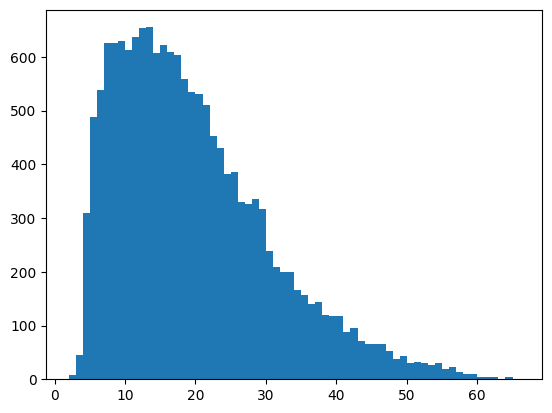

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from os import truncate
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   2, 139,   3, 679], dtype=int32)

In [ ]:
classes = set(train_labels)
print(classes)

{0, 1, 2, 3, 4, 5}


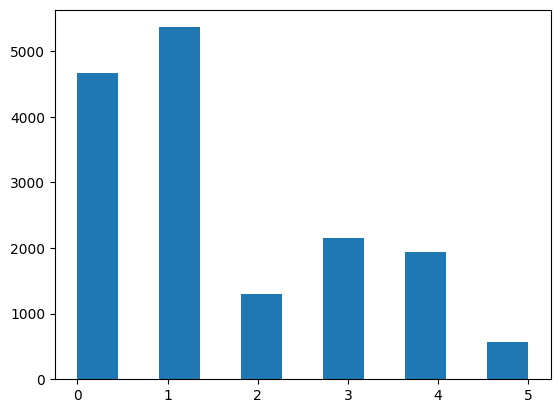

In [ ]:
plt.hist(train_labels,bins=11)
plt.show()

sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

## Task 5: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(

              loss= 'sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 6: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 69s 99ms/step - loss: 1.3689 - accuracy: 0.4684 - val_loss: 0.9339 - val_accuracy: 0.6665
Epoch 2/20
500/500 [==============================] - 30s 61ms/step - loss: 0.6543 - accuracy: 0.7773 - val_loss: 0.6273 - val_accuracy: 0.7870
Epoch 3/20
500/500 [==============================] - 35s 71ms/step - loss: 0.3578 - accuracy: 0.8834 - val_loss: 0.4754 - val_accuracy: 0.8440
Epoch 4/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2465 - accuracy: 0.9235 - val_loss: 0.4282 - val_accuracy: 0.8625
Epoch 5/20
500/500 [==============================] - 32s 64ms/step - loss: 0.1786 - accuracy: 0.9464 - val_loss: 0.4007 - val_accuracy: 0.8715
Epoch 6/20
500/500 [==============================] - 34s 68ms/step - loss: 0.1367 - accuracy: 0.9584 - val_loss: 0.3946 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 31s 62ms/step - loss: 0.1079 - accuracy: 0.9657 - val_loss: 0.4012 - val_accuracy:

## Task 7: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

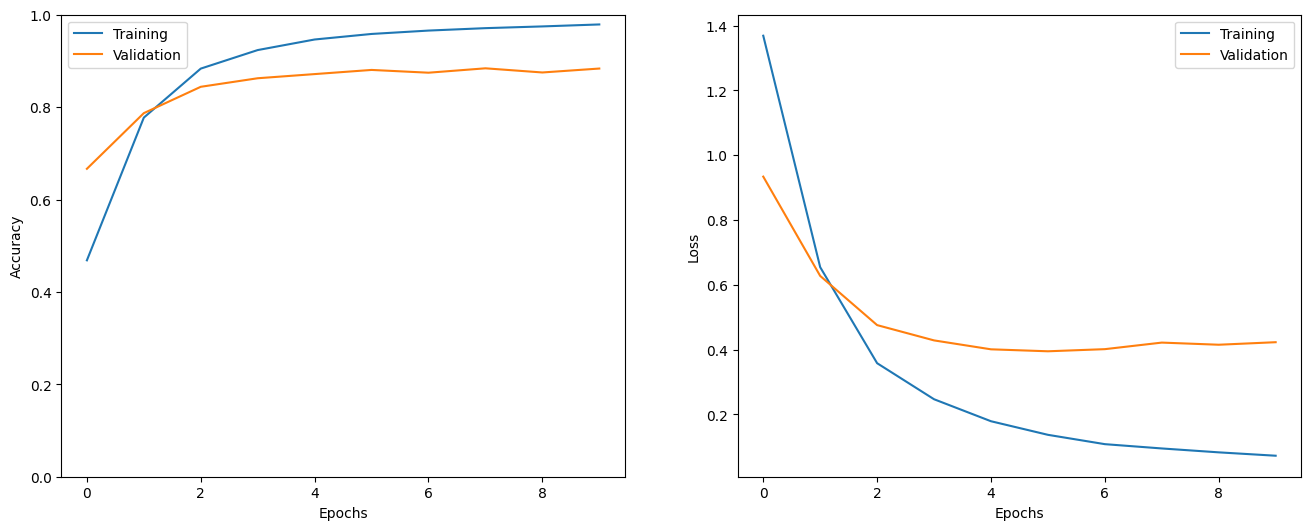

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 18ms/step - loss: 0.4016 - accuracy: 0.8840


In [ ]:
index_to_class = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p= model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence:  i can t look at for too long without feeling depressed
Emotion:  sadness
1/1 [==============================] - 2s 2s/step
Predicted Emotion: sadness


In [ ]:
preds = model.predict(test_seq)
preds_labels = np.argmax(preds, axis=1)

63/63 [==============================] - 1s 17ms/step


In [ ]:
# Define the classes
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


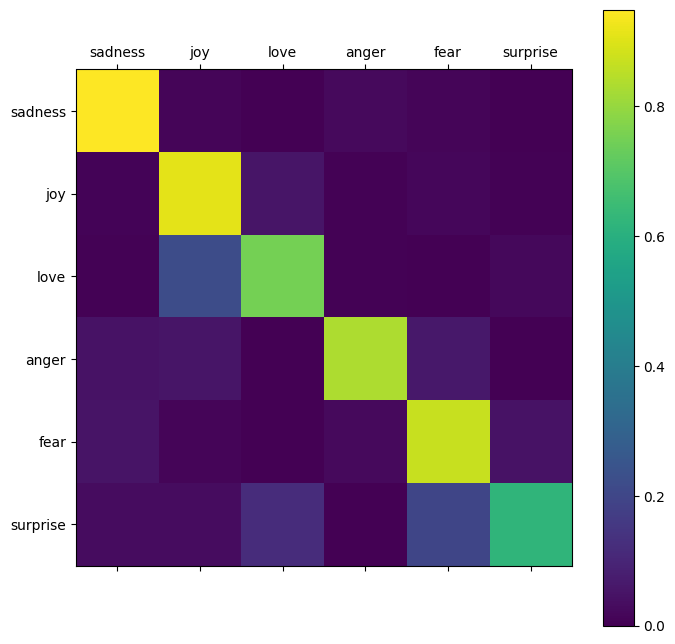

In [ ]:
show_confusion_matrix(test_labels, preds_labels, list(classes))